In [1]:
from __future__ import division
import sys
import os
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
import pandas as pd
from concurrent.futures import ProcessPoolExecutor, wait
from scipy import optimize as sco
from glob import glob
import re
from matplotlib.colors import LogNorm

In [2]:
nb_dir = '/home/dup193/work/double_pulse/stat_analysis'
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    
from likelihood import BinnedPoissonLikelihood
from event_selection import EventSelection, EventSelectionTwoBin
from helper_functions import build_histograms, build_error_histograms, plot_histogram, get_default_binning,\
build_uncert_histograms,plot_histogram_ratio
from stats import sample_from_hist,ts_to_pval
from signal_injector import SignalInjector
from scan_neyman_plane import scan_neyman_plane
from limit_calculator import LimitCalculatorNoDF

In [3]:
data_tc0 = np.load('/fastio2/dasha/double_pulse/data_FLUXES_NuTau_1_1.npy',mmap_mode='r')
data_tn0 = np.load('/fastio2/dasha/double_pulse/data_FLUXES_NuTau_2_1.npy',mmap_mode='r')
data_mc0 = np.load('/fastio2/dasha/double_pulse/data_FLUXES_NuMu_1_1.npy',mmap_mode='r')
data_mn0 = np.load('/fastio2/dasha/double_pulse/data_FLUXES_NuMu_2_1.npy',mmap_mode='r')
data_ec0 = np.load('/fastio2/dasha/double_pulse/data_FLUXES_NuE_1_1.npy',mmap_mode='r')
data_en0 = np.load('/fastio2/dasha/double_pulse/data_FLUXES_NuE_2_1.npy',mmap_mode='r')
data_eg0 = np.load('/fastio2/dasha/double_pulse/data_FLUXES_NuE_3_1.npy',mmap_mode='r')
data_c0 = np.load('/fastio2/dasha/double_pulse/data_MuonGun_all.npy',mmap_mode='r')

In [4]:
data_tc,data_tn,data_mc,data_mn,data_ec,data_en,data_eg,data_c = \
    EventSelection(data_tc0,data_tn0,data_mc0,data_mn0,data_ec0,data_en0,data_eg0,data_c0)
print(data_tc0.shape,data_tn0.shape,data_mc0.shape,data_mn0.shape,data_ec0.shape,data_en0.shape,data_eg0.shape,data_c0.shape)
print(data_tc.shape,data_tn.shape,data_mc.shape,data_mn.shape,data_ec.shape,data_en.shape,data_eg.shape,data_c.shape)

(128278,) (27754,) (462405,) (54601,) (420185,) (72626,) (4267,) (246367,)
(8311,) (47,) (330,) (105,) (66,) (62,) (20,) (245,)


In [5]:
datab_tc,datab_tn,datab_mc,datab_mn,datab_ec,datab_en,datab_eg,datab_c = \
    EventSelectionTwoBin(data_tc0,data_tn0,data_mc0,data_mn0,data_ec0,data_en0,data_eg0,data_c0, COR1=[0.1,0.8],COR2=[0.95,0.3])
print(data_tc0.shape,data_tn0.shape,data_mc0.shape,data_mn0.shape,data_ec0.shape,data_en0.shape,data_eg0.shape,data_c0.shape)
print(datab_tc.shape,datab_tn.shape,datab_mc.shape,datab_mn.shape,datab_ec.shape,datab_en.shape,datab_eg.shape,datab_c.shape)

(128278,) (27754,) (462405,) (54601,) (420185,) (72626,) (4267,) (246367,)
(797,) (95,) (4085,) (183,) (8965,) (415,) (85,) (803,)


In [6]:
#Teo bin histogramm
weight_name = 'weight_val_0'
weight_name_c = 'weight_val'
wtype = 'nom'
secs_per_year = 31536000
years = 10
sig = [sum(data_tc[weight_name][wtype]), sum(data_tn[weight_name][wtype])+sum(data_mc[weight_name][wtype])+\
       sum(data_mn[weight_name][wtype])+sum(data_ec[weight_name][wtype])+sum(data_en[weight_name][wtype])+\
       sum(data_eg[weight_name][wtype])+sum(data_c[weight_name_c])]

bkg = [sum(datab_tc[weight_name][wtype]), sum(datab_tn[weight_name][wtype])+sum(datab_mc[weight_name][wtype])+\
       sum(datab_mn[weight_name][wtype])+sum(datab_ec[weight_name][wtype])+sum(datab_en[weight_name][wtype])+\
       sum(datab_eg[weight_name][wtype])+sum(datab_c[weight_name_c])]

sig = np.array(sig)*secs_per_year*years
bkg = np.array(bkg)*secs_per_year*years


print(sig)
print(bkg)

[6.83440944 0.32878958]
[ 1.14198854 13.17970927]


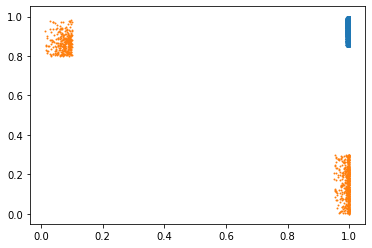

In [7]:
plt.scatter(data_tc['preds']['n1'],data_tc['preds']['n3'], s =0.9)
plt.scatter(datab_tc['preds']['n1'],datab_tc['preds']['n3'], s =0.9)

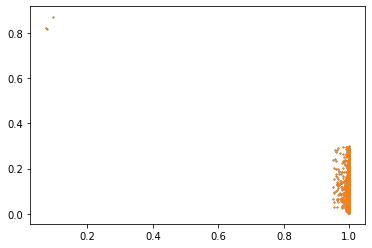

In [8]:
plt.scatter(datab_c['preds']['n1'],datab_c['preds']['n3'], s =0.9)
plt.scatter(datab_c['preds']['n1'],datab_c['preds']['n3'], s =0.9)

In [9]:
n_jobs=100
n_samples=100000
mu_bins = np.linspace(0, 25, 1001)
ts_bins = np.linspace(0, 200, 2001)
out_path ="/home/dup193/work/double_pulse/twobin_test/ts_dist/"

In [10]:
sig_exp, bkg_exp = np.sum(sig), np.sum(bkg) 
print(sig_exp, bkg_exp)

7.1631990181464165 14.321697817856851


In [12]:
def main(n_jobs, n_samples, sig, bkg, sig_exp, bkg_exp,out_path):
    global mu_bins,ts_bins
    
    ts_bins = ts_bins - np.diff(ts_bins)[0] / 2.
    n_samples_per_mu = n_samples
    
    if not os.path.isdir(out_path):
        os.makedirs(out_path)
    
    hists, ts_e = scan_neyman_plane(
        sig, bkg, bkg_exp,
        mu_bins, ts_bins, n_samples_per_mu,
        n_jobs=n_jobs, save=True,
        out_path=out_path)


if __name__ == '__main__':
    main(n_jobs,n_samples,sig, bkg, sig_exp, bkg_exp,out_path)

In [11]:
def fill_hist(name_out):
    hists = np.zeros((len(mu_bins), len(ts_bins) - 1))
    for file_name in glob(name_out+'*'):
        sp = re.split('_|\.|/',file_name)
        mu = float(sp[-3]+"."+sp[-2])
        i = np.where(mu_bins==mu)
        x = np.load(file_name, mmap_mode="r")['arr_0']
        hist, ts_e = np.histogram(x, bins=ts_bins)
        hist = hist / float(np.sum(hist))
        hists[i] = hist
    return hists

In [12]:
name_out1 = "/home/dup193/work/double_pulse/twobin_test/ts_dist/"
hists1 = fill_hist(name_out1)

In [13]:
print(sum(hists1))

[344.35278 128.46109  89.12735 ...   0.        0.        0.     ]


In [14]:
def plot_ts(hists):
    vmin = np.min([np.min(hist) for hist in hists])
    vmax = np.max([np.max(hist) for hist in hists])
    fig = plt.figure(figsize=(10, 10),facecolor ='w')
    plt.rcParams.update({'font.size': 16})
    plt.ticklabel_format(axis='both', style='sci', scilimits=(-5,5))
    ax = fig.add_subplot()
    ax.set_xlim(0,25)
    for i in range(len(mu_bins) - 1):
        Xe, Ye = np.meshgrid(ts_bins, [mu_bins[i], mu_bins[i+1]])
        im = ax.pcolormesh(Xe, Ye, np.atleast_2d(hists[i]), vmin=vmin+1e-4, vmax=vmax, norm=LogNorm())
    plt.colorbar(im)
    ax.set_xlabel('TS: $-\log(\mathcal{L}(\mu_t) / \mathcal{L}(\hat{\mu}))$')
    ax.set_ylabel(r'Mean signal expectation $\mu_t$')
    # plt.savefig('plots/neyman_plane_hans.pdf', bbox_inches='tight')
    #ax.imshow(hists,origin='lower',interpolation='none', extent=[0,20,0,20])

/home/dup193/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


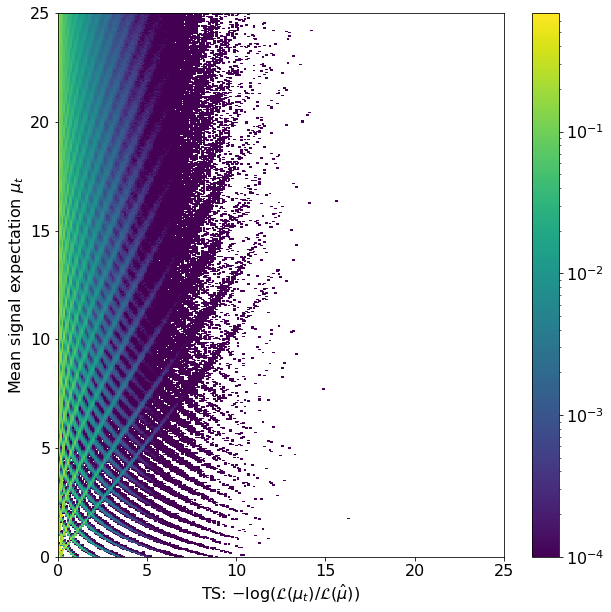

In [17]:
plot_ts(hists1)

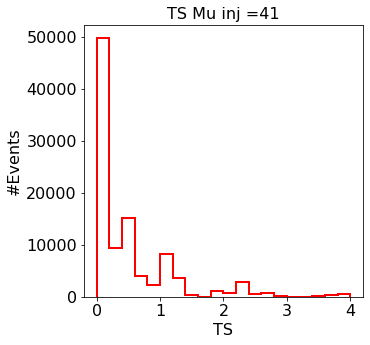

In [19]:
from glob import glob
import re 
file_name = "/home/dup193/work/double_pulse/twobin_test/ts_dist/ts_mu_4.0.npz"
x = np.load(file_name, mmap_mode="r")['arr_0']
fig = plt.figure(figsize=(5, 5),facecolor ='w')
ax = fig.add_subplot(111)
plt.rcParams.update({'font.size': 16})
plt.ticklabel_format(axis='both', style='sci', scilimits=(-5,5))
ax.set_xscale('linear')
ax.set_yscale('linear')
ax.set_title("TS Mu inj =41", fontsize = 16)
ax.set_xlabel("TS", fontsize = 16)                                                              
ax.set_ylabel("#Events", fontsize = 16)                                                   
ax.hist(x, bins = 20, histtype = 'step',edgecolor ='r', lw =2, range =[0,4], label = "NuTauCC")  
#plt.legend(loc=loc)
plt.show()


In [15]:
limit_calculator = LimitCalculatorNoDF(
    'baseline', flux_systematic=False,sig = sig, bkg =bkg, 
     scan_path='/home/dup193/work/double_pulse/twobin_test/ts_dist/',
     livetime=1)

In [16]:
likelihood = BinnedPoissonLikelihood(limit_calculator.sig, limit_calculator.bkg, limit_calculator.random_state)
limit_calculator.set_likelihood(likelihood)

In [17]:
tss = limit_calculator.__load_acceptance_values__(return_ts=True)

In [18]:
tss.shape

(1001, 100000)

In [19]:
mus = limit_calculator.mus

In [20]:
def load_ts(tss):
    ts_bins = np.linspace(0, 200, 2001)
    ts_bins = ts_bins - np.diff(ts_bins)[0] / 2.
    hists = []
    for i in range(len(mus)):
        hist_i, edges = np.histogram(tss[i], bins=ts_bins, density=False)
        hist_i = hist_i / float(np.sum(hist_i))
        hists.append(hist_i)
    return hists

In [21]:
ts_hist = load_ts(tss)

Text(0.5, 0, 'TS')

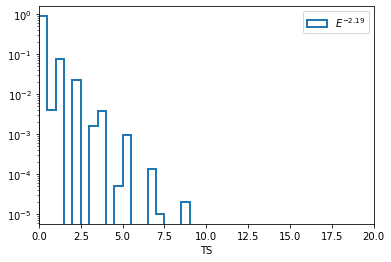

In [22]:
ts_center = (ts_bins[1:] + ts_bins[:-1]) / 2.
plt.hist(ts_center, bins=ts_bins[::5],
         weights=hists1[0],
         histtype='step', lw=2,
         label='$E^{-2.19}$')
plt.yscale('log')
plt.xlim(0, 20)
plt.legend()
plt.xlabel('TS')

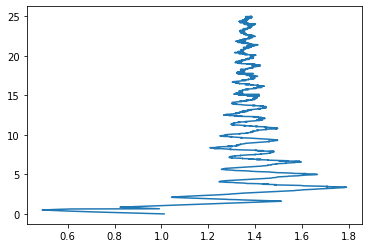

In [23]:
plt.plot(limit_calculator.acc_vals, mus)

Text(0.5, 0, 'TS')

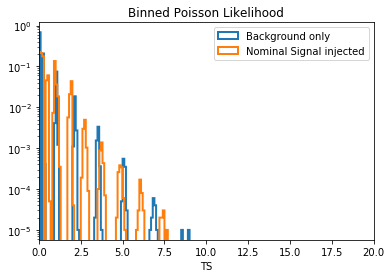

In [24]:
ts_center = (ts_bins[1:] + ts_bins[:-1]) / 2.
plt.title('Binned Poisson Likelihood')
plt.hist(ts_center, bins=ts_bins,
         weights=hists1[0],
         histtype='step', lw=2,
         label='Background only')
plt.hist(ts_center, bins=ts_bins,
         weights=hists1[81],
         histtype='step', lw=2,
         label='Nominal Signal injected')
plt.yscale('log')
plt.xlim(0, 20)
plt.legend()
plt.xlabel('TS')

No handles with labels found to put in legend.


Text(0.5, 0, 'TS')

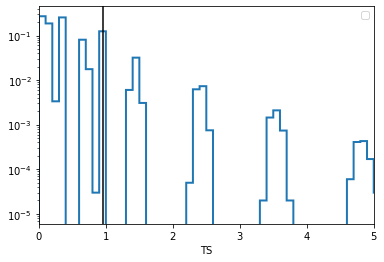

In [25]:
idx = 40
plt.hist(ts_center, bins=ts_bins,
         weights=hists1[idx],
         histtype='step', lw=2)
plt.axvline(limit_calculator.acc_vals[idx], color='k')
plt.yscale('log')
plt.xlim(0, 5)
plt.legend()
plt.xlabel('TS')

In [26]:
samples_bkg = limit_calculator.create_samples()

In [27]:
lmds = np.linspace(0, 30, 301)

llh_vals = []
for lmdi in lmds:
    llh_val = likelihood.log_likelihood(lmdi, samples_bkg[7])
    llh_vals.append(llh_val)

ts_vals = []
for lmdi in lmds:
    _, lmd = likelihood.fit_lmd_best(lmdi, samples_bkg[7])
    ts_val = likelihood.test_statistic_best(
        lmd, lmdi, samples_bkg[7])
    ts_vals.append(-ts_val)

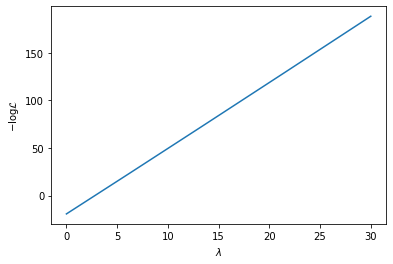

In [28]:
plt.plot(lmds, llh_vals)
plt.xlabel(r'$\lambda$')
plt.ylabel(r'$-\log \mathcal{L}$');

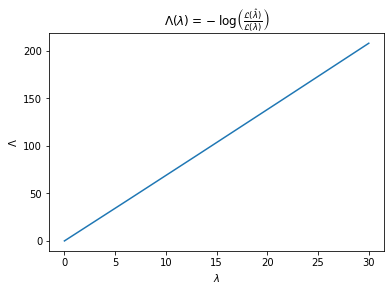

In [29]:
plt.plot(lmds, ts_vals)
plt.title(r'$\Lambda(\lambda) = - \log \left(\frac{\mathcal{L}(\hat{\lambda})}{\mathcal{L}(\lambda)} \right)$')
plt.xlabel(r'$\lambda$')
plt.ylabel(r'$\Lambda$');

In [37]:
def find_int_trials(samples):
    print(samples.shape)
    ss = np.sum(samples, axis =(1))
    print('max',np.max(ss),np.argmax(ss))
    print('min',np.min(ss),np.argmin(ss))
    return np.argmax(ss), np.argmin(ss)

In [38]:
maxt, mint = find_int_trials(samples_bkg)

(1000, 2)
max 26 405
min 4 564


In [39]:
samples_bkg

array([[ 1,  9],
       [ 0, 14],
       [ 1, 17],
       ...,
       [ 0, 16],
       [ 2, 13],
       [ 1, 15]])

In [40]:
def plot_ts_acval(limit_calculator,hists,samples_bkg,n1,n2):
    fig = plt.figure(figsize=(10, 10),facecolor ='w')
    vmin = np.min([np.min(hist) for hist in hists])
    vmax = np.max([np.max(hist) for hist in hists])

    ts_vals = []
    for mu in mus:
        lmd = mu / limit_calculator.sig_exp
        ts_val, lmd = likelihood.fit_lmd_best(lmd, samples_bkg[n1])
        ts_vals.append(-ts_val)
    
    ts_vals2 = []
    for mu in mus:
        lmd = mu / limit_calculator.sig_exp
        ts_val, lmd = likelihood.fit_lmd_best(lmd, samples_bkg[n2])
        ts_vals2.append(-ts_val)

    fig, ax = plt.subplots(figsize=(10, 10),facecolor ='w')
    for i in range(len(mus) - 1):
        Xe, Ye = np.meshgrid(ts_bins, [mus[i], mus[i+1]])
        im = ax.pcolormesh(Xe, Ye, np.atleast_2d(hists[i]), norm=LogNorm())# , vmin=vmin+1e-4, vmax=vmax
    plt.plot(ts_vals, mus, color='k', label='Scan for example experiment')
    plt.plot(ts_vals2, mus, color='k', ls='--', label='Scan for example experiment')
    plt.plot(limit_calculator.acc_vals, mus, color='r', label='Critical values')
    ax.set_xlabel('TS: $-\log(\mathcal{L}(\mu_t) / \mathcal{L}(\hat{\mu}))$')
    ax.set_ylabel(r'Mean signal expectation $\mu_t$')
    plt.xlim(0, 25)
    ylim_lower = 0
    ylim_upper = 25
    plt.ylim(ylim_lower, ylim_upper)
    plt.legend(loc =1)
    ax2 = ax.twinx()
    ax2.set_ylabel(r'Mean rel. $\nu_{\tau}$ flux norm $\lambda_t$')
    ax2.plot(ts_vals2, mus/limit_calculator.sig_exp, color='k', ls='--', label='Scan for example experiment')
    ax2.set_ylim(ylim_lower/limit_calculator.sig_exp, ylim_upper/limit_calculator.sig_exp)
    plt.colorbar(im, pad=0.15)

<Figure size 720x720 with 0 Axes>

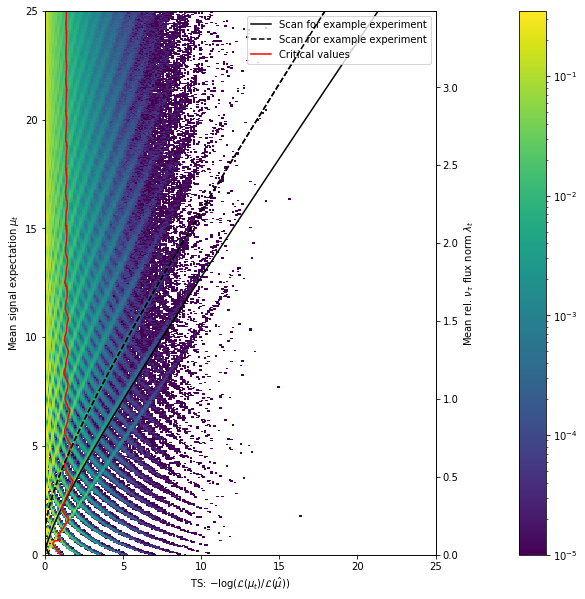

In [41]:
plot_ts_acval(limit_calculator,hists1,samples_bkg,570,409)

In [42]:
flux_norm = 2.12
limit_calculator.calculate_limits(limit_calculator.acc_vals, flux_norm)

100%|██████████| 1000/1000 [00:18<00:00, 53.05it/s]


In [43]:
limit_calculator.average_upper_limit

0.9151069212783408

In [44]:
print(np.std(limit_calculator.upper_limits_flux))

0.51067261461568


In [45]:
np.sum(limit_calculator.lower_limits_flux==0)/len(limit_calculator.lower_limits_flux)

0.906

Text(0.5, 1.0, 'Fitting with $E^{-2.87}$')

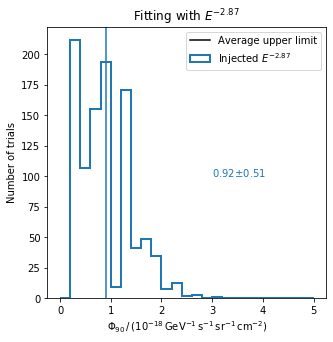

In [46]:
fig = plt.figure(figsize=(5, 5),facecolor ='w')
ul_bins = np.linspace(0, 5, 26)
plt.hist(limit_calculator.upper_limits_flux, bins=ul_bins, histtype='step', lw=2, label='Injected $E^{-2.87}$')
plt.axvline(limit_calculator.average_upper_limit)

plt.text(3,100, "{0:.2f}$\pm${1:.2f}".format(limit_calculator.average_upper_limit,np.std(limit_calculator.upper_limits_flux)), color = 'C0')

plt.legend(fontsize = 'x-small')
plt.plot([], [], color='k', ls='-', label='Average upper limit')
plt.legend()
plt.xlabel('$\Phi_{90} \, / \, (10^{-18} \, \mathrm{GeV}^{-1} \, \mathrm{s}^{-1} \, \mathrm{sr}^{-1} \, \mathrm{cm}^{-2})$')
plt.ylabel('Number of trials')
plt.title('Fitting with $E^{-2.87}$')